<a href="https://colab.research.google.com/github/dong-uk-kim97/Exploration/blob/main/Exploration_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. konlpy 설치 및 라이브러리 불러오기

In [1]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences # 케라스 전처리 도구로 패딩
from collections import Counter
import os
from konlpy.tag import Mecab # Mecab 형태소 분석기
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 1. 데이터 준비와 확인

In [27]:
train_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/sentiment_classification/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. 데이터로더 구성

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key , _  in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석과 가공

- 데이터셋 내 문장 길이 분포 
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences를 활용한 패딩 추가


In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens) # 최대 길이
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# 패딩 추가
# 가장 마지막 위치의 단어가 state에 가장 많은 영향을 미치므로 padding은 pre로 지정.
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


# 4. 모델 구성 및 validation set 구성

In [8]:
# 학습 데이터 중 20000개를 validation set으로 사용
X_val = X_train[:20000]   
y_val = y_train[:20000]

partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [9]:
vocab_size = 10000
word_vector_dim = 100

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
lstm.add(keras.layers.LSTM(8))
lstm.add(keras.layers.Dense(8, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 3488      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________


In [10]:
vocab_size = 10000
word_vector_dim = 100

# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))) 
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(16, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          11216     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 16)               

In [11]:
vocab_size = 10000
word_vector_dim = 100

# one GlobalAveragePooling layer
simple = keras.Sequential()
simple.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
simple.add(keras.layers.GlobalAveragePooling1D())
simple.add(keras.layers.Dense(8, activation='relu'))
simple.add(keras.layers.Dense(1, activation='sigmoid'))

simple.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 8)                 808       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,000,817
Trainable params: 1,000,817
Non-trainable params: 0
_________________________________________________________________


# 5. 모델 훈련 개시

In [12]:
# lstm
epochs = 5

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 5s 9ms/step - loss: 0.4691 - accuracy: 0.7963 - val_loss: 0.3598 - val_accuracy: 0.8482
Epoch 2/5
247/247 [==============================] - 2s 7ms/step - loss: 0.3323 - accuracy: 0.8619 - val_loss: 0.3425 - val_accuracy: 0.8514
Epoch 3/5
247/247 [==============================] - 2s 7ms/step - loss: 0.3039 - accuracy: 0.8740 - val_loss: 0.3403 - val_accuracy: 0.8520
Epoch 4/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2828 - accuracy: 0.8831 - val_loss: 0.3429 - val_accuracy: 0.8523
Epoch 5/5
247/247 [==============================] - 2s 7ms/step - loss: 0.2642 - accuracy: 0.8916 - val_loss: 0.3482 - val_accuracy: 0.8546


In [13]:
# 1-D CNN
epochs = 3

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 3s 7ms/step - loss: 0.4421 - accuracy: 0.7889 - val_loss: 0.3506 - val_accuracy: 0.8450
Epoch 2/3
247/247 [==============================] - 2s 6ms/step - loss: 0.3023 - accuracy: 0.8727 - val_loss: 0.3315 - val_accuracy: 0.8571
Epoch 3/3
247/247 [==============================] - 2s 6ms/step - loss: 0.2442 - accuracy: 0.9030 - val_loss: 0.3369 - val_accuracy: 0.8551


In [14]:
# one GlobalAveragePooling layer
simple.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_simple = simple.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
247/247 [==============================] - 2s 5ms/step - loss: 0.5680 - accuracy: 0.7492 - val_loss: 0.4186 - val_accuracy: 0.8274
Epoch 2/3
247/247 [==============================] - 1s 5ms/step - loss: 0.3771 - accuracy: 0.8419 - val_loss: 0.3606 - val_accuracy: 0.8462
Epoch 3/3
247/247 [==============================] - 1s 5ms/step - loss: 0.3415 - accuracy: 0.8567 - val_loss: 0.3526 - val_accuracy: 0.8497


모델 평가

In [15]:
# LSTM
print("LSTM")
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("-------------------------------------------------------------------------")

# 1-D CNN
print("1-D CNN")
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("-------------------------------------------------------------------------")

# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = simple.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 4s - loss: 0.3620 - accuracy: 0.8471 - 4s/epoch - 2ms/step
[0.36204200983047485, 0.8470614552497864]
-------------------------------------------------------------------------
1-D CNN
1537/1537 - 3s - loss: 0.3455 - accuracy: 0.8525 - 3s/epoch - 2ms/step
[0.34553223848342896, 0.8525133728981018]
-------------------------------------------------------------------------
GlobalAveragePooling1D layer
1537/1537 - 2s - loss: 0.3624 - accuracy: 0.8456 - 2s/epoch - 2ms/step
[0.36242032051086426, 0.8455967903137207]


# 6.Loss, Accuracy 시각화

그래프 시각화 - LSTM

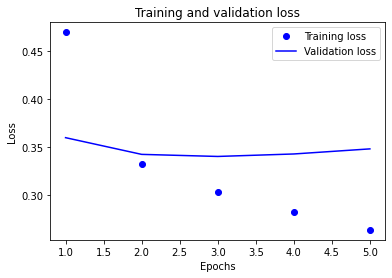

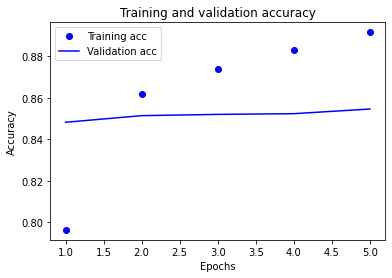

In [16]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# 그림을 초기화
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

그래프 시각화 - 1-D CNN

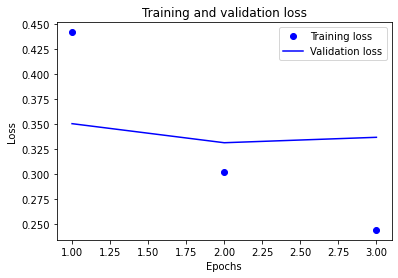

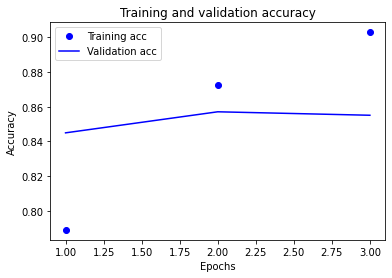

In [17]:
history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

그래프 시각화 - GlobalAveragePooling1D layer

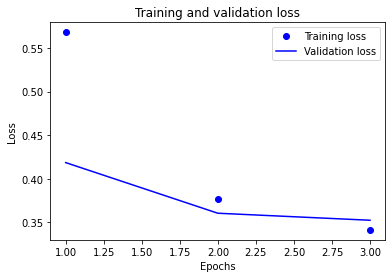

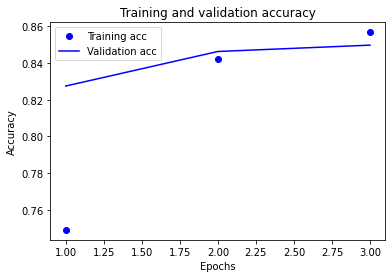

In [18]:
history_dict = history_simple.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 7. 학습된 Embedding 레이어 분석

In [19]:
embedding_lstm = lstm.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = cnn.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = simple.layers[0]
weights_simple = embedding_simple.get_weights()[0]

word2vec_file_path_lstm = '/content/drive/MyDrive/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_cnn = '/content/drive/MyDrive/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word2vec_file_path_simple = '/content/drive/MyDrive/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = simple.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors_lstm = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)

word_vectors_cnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)

word_vectors_simple = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['재미']
vector

array([ 0.00531096,  0.02135717,  0.06036973, -0.05611754, -0.03388058,
        0.04766459,  0.09751822,  0.01969919,  0.10673527,  0.00553961,
       -0.06393624,  0.05882081, -0.02737525, -0.02963301, -0.0361198 ,
        0.08635226, -0.00505785, -0.04903755, -0.02611034, -0.14444138,
        0.04017559, -0.01926279,  0.03396042, -0.01537915, -0.06385084,
        0.00471526,  0.07850073,  0.03936682,  0.00527933, -0.0231904 ,
       -0.0099586 , -0.03006392,  0.02307251,  0.03414249, -0.00613718,
       -0.04375296,  0.00881475, -0.01521217,  0.0270629 ,  0.07326045,
       -0.10055137,  0.05220232,  0.06660135,  0.03578389,  0.04663274,
        0.03096722, -0.03223411,  0.04832842,  0.01929047, -0.00876016,
       -0.01077865, -0.01085798,  0.0329261 ,  0.04467646, -0.19933386,
        0.14545378,  0.09780562,  0.06697103,  0.10209822, -0.049952  ,
       -0.05713513, -0.02958745,  0.0242043 , -0.07026041,  0.01987545,
        0.0127962 ,  0.15418111,  0.01628734, -0.03361598,  0.04

In [36]:
word_vectors.similar_by_word("재미")

[('너무', 0.6356413960456848),
 ('가치', 0.6093034744262695),
 ('최대', 0.5828654170036316),
 ('그냥', 0.5796778202056885),
 ('완전', 0.5762255787849426),
 ('이렇게', 0.5647052526473999),
 ('빼', 0.563108503818512),
 ('정말', 0.5604767203330994),
 ('레이', 0.5480203032493591),
 ('넘', 0.5420159101486206)]

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['재미']
vector

array([-3.56533825e-02,  8.21857750e-02, -4.26928774e-02, -5.48555851e-02,
        4.23825346e-02, -1.01158269e-01,  8.03352073e-02, -2.54795682e-02,
       -9.07088295e-02, -6.86131120e-02,  2.26571187e-02,  3.12554613e-02,
       -6.11566268e-02,  5.38873561e-02, -5.36697321e-02, -6.67239539e-04,
       -8.16882402e-02, -5.82717638e-03,  3.63946110e-02, -3.21140476e-02,
        1.70629453e-02,  1.21380091e-01, -4.39551547e-02,  9.70781874e-03,
       -3.47234942e-02,  1.70244165e-02, -1.15523912e-01,  2.36896798e-02,
        3.58846784e-02,  6.38255442e-05, -4.07677218e-02, -3.40257958e-02,
       -8.94649606e-03, -1.47858942e-02, -1.44892469e-01,  8.99335369e-02,
        9.29727778e-02,  3.35599855e-02,  4.05855244e-03,  3.76610532e-02,
       -3.02533079e-02, -2.78825797e-02,  7.53981546e-02, -9.20695718e-03,
        4.04153727e-02, -1.02066167e-01,  8.31923336e-02, -5.15182056e-02,
       -3.26002799e-02, -1.14546595e-02,  2.17293971e-03, -1.15465127e-01,
       -8.92373174e-03, -

In [38]:
word_vectors.similar_by_word("재미")

[('라인', 0.628969669342041),
 ('당장', 0.6007945537567139),
 ('녹', 0.597942590713501),
 ('턱없이', 0.5709643363952637),
 ('제미', 0.5703440308570862),
 ('송', 0.5702739953994751),
 ('부모', 0.5536139607429504),
 ('매우', 0.5530441999435425),
 ('앨런', 0.5412382483482361),
 ('볼거리', 0.5400121212005615)]

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_simple, binary=False)
vector = word_vectors['재미']
vector

array([-0.03923504,  0.1130901 ,  0.01876753,  0.0032308 ,  0.04775185,
        0.04332221, -0.02619516,  0.03975026,  0.0487186 ,  0.01643897,
       -0.0634067 ,  0.01101326, -0.10124979,  0.05271785, -0.04344707,
        0.03770953,  0.07085124,  0.08346158, -0.03016632,  0.035007  ,
        0.02991319,  0.0537154 ,  0.11391243, -0.01514698,  0.08707146,
       -0.13706668,  0.07715339,  0.00125257,  0.00562147,  0.01907247,
       -0.08165149,  0.024127  , -0.03964928,  0.02765276, -0.07182743,
        0.11762605, -0.1806983 ,  0.10843413,  0.08611084,  0.07169566,
        0.01028615, -0.06897793,  0.0774884 ,  0.04979206,  0.05076767,
        0.15074876,  0.03066442, -0.05604044, -0.05035167,  0.10798031,
       -0.08346434, -0.10063542,  0.09017699,  0.03338666,  0.08068294,
        0.06265757,  0.13830262,  0.00554341, -0.31003988, -0.03498385,
       -0.05401101,  0.01222307,  0.04228582,  0.04694744,  0.09972528,
       -0.1146077 , -0.01187872, -0.02644362,  0.01183056,  0.01

In [40]:
word_vectors.similar_by_word("재미")

[('..', 0.8858311176300049),
 ('로', 0.8785592317581177),
 ('네', 0.8753498792648315),
 ('...', 0.8753357529640198),
 ('나오', 0.8589136600494385),
 ('이런', 0.8584960699081421),
 ('배우', 0.856569230556488),
 ('성', 0.8448890447616577),
 ('하', 0.8447354435920715),
 ('너무', 0.8435921669006348)]

# 8. 한국어 Word2Vec 임베딩을 활용하여 성능 개선

In [41]:
import pprint

path = '/content/drive/MyDrive/word2vec/word2vec_ko.model'
ko_vec = Word2Vec.load(path)

print(ko_vec.wv["배우"]) # ko_vec["배우"]방식은 deprecated라고 한다.
pprint.pprint(ko_vec.wv.most_similar("재미")) #마찬가지로 ko_vec.most_similar() 방식도 deprecated. 지양하자.

ko_vec = ko_vec.wv # ko_vec.wv대신 ko_vec을 사용하면 아래에서도 deprecated 경고 발생   

[-0.58881295 -4.3877287  -3.4858546  -2.3084912   0.87703085  6.4445586
 -1.1062126  -2.2230182  -0.78621733  1.9408462  -1.1357461   1.0119969
 -0.30329964 -5.455517    2.6356647  -5.2909884  -1.744448    2.5409734
  3.716852   -1.4752581  -1.1985137   3.5504315  -0.41522408 -0.2436183
  1.5218438  -3.4603841   1.1120543   0.39729053 -2.707328    1.3680482
 -4.2843776   3.014664    2.6393197   0.9804478  -1.0825127   3.6201363
  3.1546066   0.9634868   1.3677765   0.82937515  1.9380125  -2.6699877
 -0.41389105  2.7402463   3.415545   -0.37949705  4.4021254   1.2531414
  2.504994    0.33631453 -2.0658643  -3.1885884   6.659477   -5.47897
  3.1113489   1.6667893   2.8441331  -1.1597652  -0.19843072 -0.07214008
  0.47545317  4.105001   -0.20690314 -4.399607   -0.32254001  2.030352
  0.35149667 -4.0907154   1.12323    -1.873176    2.422429    1.9751279
 -0.9144355   4.34507    -1.0122209   3.4604955  -2.2505796  -5.2072535
  1.4032923   0.7049264   2.6884458   0.11147156  1.4308741   0.03

In [29]:
vocab_size_ko_vec = 10000
word_vector_dim_ko_vec = 100

embedding_matrix = np.random.rand(vocab_size_ko_vec, word_vector_dim_ko_vec)

for i in range(4,vocab_size_ko_vec):
    if index_to_word[i] in ko_vec:
        embedding_matrix[i] = ko_vec[index_to_word[i]]

In [30]:
vocab_size = 10000
word_vector_dim = 100

# LSTM
lstm = keras.Sequential()
lstm.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
lstm.add(keras.layers.LSTM(128))
lstm.add(keras.layers.Dense(128, activation='relu'))
lstm.add(keras.layers.Dense(1, activation='sigmoid'))

lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


In [31]:
# 1-D CNN
cnn = keras.Sequential()
cnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
cnn.add(keras.layers.Dropout(0.5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.MaxPooling1D(5))
cnn.add(keras.layers.Conv1D(512, 7, activation='relu'))
cnn.add(keras.layers.GlobalMaxPooling1D())
cnn.add(keras.layers.Dense(256, activation='relu'))
cnn.add(keras.layers.Dense(1, activation='sigmoid'))

cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 dropout_1 (Dropout)         (None, 41, 100)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 35, 512)           358912    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 512)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 512)            1835520   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                     

In [32]:

epochs = 4

lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_lstm = lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Epoch 1/4
247/247 [==============================] - 5s 13ms/step - loss: 0.4702 - accuracy: 0.7718 - val_loss: 0.3945 - val_accuracy: 0.8201
Epoch 2/4
247/247 [==============================] - 3s 10ms/step - loss: 0.3507 - accuracy: 0.8444 - val_loss: 0.3356 - val_accuracy: 0.8528
Epoch 3/4
247/247 [==============================] - 3s 10ms/step - loss: 0.3015 - accuracy: 0.8707 - val_loss: 0.3208 - val_accuracy: 0.8597
Epoch 4/4
247/247 [==============================] - 3s 10ms/step - loss: 0.2703 - accuracy: 0.8869 - val_loss: 0.3232 - val_accuracy: 0.8637


In [33]:
epochs = 10

history_cnn = cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 6s 21ms/step - loss: 0.6322 - accuracy: 0.6705 - val_loss: 0.5103 - val_accuracy: 0.7599
Epoch 2/10
247/247 [==============================] - 5s 21ms/step - loss: 0.5006 - accuracy: 0.7558 - val_loss: 0.4462 - val_accuracy: 0.8013
Epoch 3/10
247/247 [==============================] - 6s 23ms/step - loss: 0.4481 - accuracy: 0.7895 - val_loss: 0.4167 - val_accuracy: 0.8080
Epoch 4/10
247/247 [==============================] - 6s 26ms/step - loss: 0.4156 - accuracy: 0.8084 - val_loss: 0.3756 - val_accuracy: 0.8359
Epoch 5/10
247/247 [==============================] - 5s 21ms/step - loss: 0.3891 - accuracy: 0.8221 - val_loss: 0.3674 - val_accuracy: 0.8349
Epoch 6/10
247/247 [==============================] - 5s 21ms/step - loss: 0.3705 - accuracy: 0.8326 - val_loss: 0.3589 - val_accuracy: 0.8425
Epoch 7/10
247/247 [==============================] - 5s 20ms/step - loss: 0.3547 - accuracy: 0.8410 - val_loss: 0.3507 - val_accuracy: 0.8465

In [34]:
# LSTM
results_lstm = lstm.evaluate(X_test, y_test, verbose=2)
print(results_lstm)

# 1-D CNN
results_cnn = cnn.evaluate(X_test, y_test, verbose=2)
print(results_cnn)

1537/1537 - 4s - loss: 0.3271 - accuracy: 0.8599 - 4s/epoch - 2ms/step
[0.3271044194698334, 0.8598775267601013]
1537/1537 - 4s - loss: 0.3435 - accuracy: 0.8515 - 4s/epoch - 2ms/step
[0.3434513211250305, 0.8515165448188782]


# 회고

NLP를 할 때 가장 중요한 것이 임베딩과 데이터 전처리라는 것을 깨달았다. 데이터 전처리를 하는 과정이 까다롭고 힘들다는 것을 깨달았다. NLP가 아닌 CV로 진로를 확정짓게 되는 노드였다.

# 출처

konlpy 설치 https://biology-statistics-programming.tistory.com/32 \
전체 코드 참조 https://velog.io/@shoulmon/SSACAIFFEL-20210114-%EB%84%A4%EC%9D%B4%EB%B2%84-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0-jvwzuadq \